# MINIST

The MNIST dataset (Modified National Institute of Standards and Technology) is one of the most well-known datasets in the field of machine learning. It consists of 70,000 grayscale images of handwritten digits (0-9), where each image is 28x28 pixels. MNIST is often used as a benchmark for evaluating the performance of different machine learning algorithms, particularly in the realm of image classification. The simplicity of the dataset makes it an excellent starting point for beginners in deep learning and for testing new architectures in research.

In [1]:
import pandas as pd
from torch.autograd import Variable
from torch.utils import data

# Basic python imports for logging and sequence generation
import itertools
import random
import pickle
import numpy as np

# Imports for Pytorch for the things we need
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torchvision import transforms, datasets

# Imports for plotting our result curves
import matplotlib
import matplotlib.pyplot as plt

## Data Load

Loading the MNIST dataset, with 60,000 training images and 10,000 testing images.

In [2]:
#########################################################
# Training and Evaluation
#########################################################


# MNIST Dataset
train_data = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

val_data = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())


maxepochs = 10
batch_size = 256
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 43042157.55it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2044656.83it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13785463.64it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2679022.47it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## CNN Model
Convolutional Neural Networks (CNNs) have shown exceptional performance in image recognition and classification tasks.

```python
# First Convolutional Layer
self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
```
- `1`: The first parameter represents the number of input channels, which is 1 for grayscale images (like those in the MNIST dataset).
- `32`: The second parameter specifies the number of output channels (or feature maps).
- `kernel_size=3`: This indicates the size of the convolutional filter, which is 3x3. The filter will slide over the input image to detect features.
- `padding=1`: Padding of 1 is added to the input image to maintain its spatial dimensions after convolution.

```python
# Average Pooling
self.pool = nn.AvgPool2d(2, 2)
```
- `AvgPool2d(2, 2)`: Average pooling with a 2x2 window and a stride of 2. This reduces the spatial dimensions of the feature maps by half, helping to downsample the input and reduce computational complexity while retaining important information.

```python
# Fully connected layer
self.fc1 = nn.Linear(24 * 7 * 7, 128)
```
- `24x7x7`: This is the number of input features to the fully connected layer, representing the flattened output from the previous layer. After two 2x2 pooling operations, the 28x28 input is reduced to 7x7, with 24 channels.
- `128`: The number of features after this layer.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128)

        # Output layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First Convolutional Layer + Pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Second Convolutional Layer + Pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flattening the output
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layer
        x = F.relu(self.fc1(x))

        # Output layer with softmax activation
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

## Training

The CNN is trained by adjusting parameters to minimize prediction errors, using categorical cross-entropy and Adam.

In [4]:
# Build model
model = Net()

# Main training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


loss_log = []
acc_log = []
val_acc_log = []
val_loss_log = []

for i in range(maxepochs):

    # Run an epoch of training
    train_running_loss = 0
    train_running_acc = 0
    model.train()
    for j,(data, y) in enumerate(trainloader):

        data, y = data.to(device), y.to(device)

        out = model(data)

        loss = criterion(out, y)

        model.zero_grad()
        loss.backward()

        optimizer.step()

        _, predicted = torch.max(out.data, 1)
        correct = (predicted == y).sum()

        train_running_loss += loss.item()
        train_running_acc += correct.item()
        loss_log.append(loss.item())
        acc_log.append(correct.item()/len(y))

    train_running_loss /= j
    train_running_acc /= len(train_data)

    # Evaluate on validation
    val_acc = 0
    val_loss = 0
    model.eval()
    for j,(data, y) in enumerate(valloader):

        data, y = data.to(device), y.to(device)

        out = model(data)

        loss = criterion(out, y)
        _, predicted = torch.max(out.data, 1)
        correct = (predicted == y).sum()

        val_acc += correct.item()
        val_loss += loss.item()

    val_acc /= len(val_data)
    val_loss /= j

    #if len(val_loss_log) != 0 and val_loss_log[-1] > val_loss:
    #  torch.save(model.state_dict(), './model.pt')

    val_acc_log.append(val_acc)
    val_loss_log.append(val_loss)

    print(f"[Epoch {i}]   Loss:  {train_running_loss}     Train Acc:  {train_running_acc*100}%      Val Acc:  {val_acc*100}%")

[Epoch 0]   Loss:  0.46140303551896006     Train Acc:  86.55333333333334%      Val Acc:  95.75%
[Epoch 1]   Loss:  0.1257984940854148     Train Acc:  96.45833333333333%      Val Acc:  97.06%
[Epoch 2]   Loss:  0.09240043664780948     Train Acc:  97.28333333333333%      Val Acc:  97.2%
[Epoch 3]   Loss:  0.07782408978758204     Train Acc:  97.75333333333333%      Val Acc:  97.83%
[Epoch 4]   Loss:  0.06870605369122365     Train Acc:  97.935%      Val Acc:  98.14%
[Epoch 5]   Loss:  0.0632302804539601     Train Acc:  98.125%      Val Acc:  98.24000000000001%
[Epoch 6]   Loss:  0.05920855319684642     Train Acc:  98.25500000000001%      Val Acc:  98.35000000000001%
[Epoch 7]   Loss:  0.05551732131717806     Train Acc:  98.35000000000001%      Val Acc:  97.24000000000001%
[Epoch 8]   Loss:  0.05187553300275507     Train Acc:  98.48%      Val Acc:  98.49%
[Epoch 9]   Loss:  0.050717262467608236     Train Acc:  98.50666666666666%      Val Acc:  98.64%


## Plot

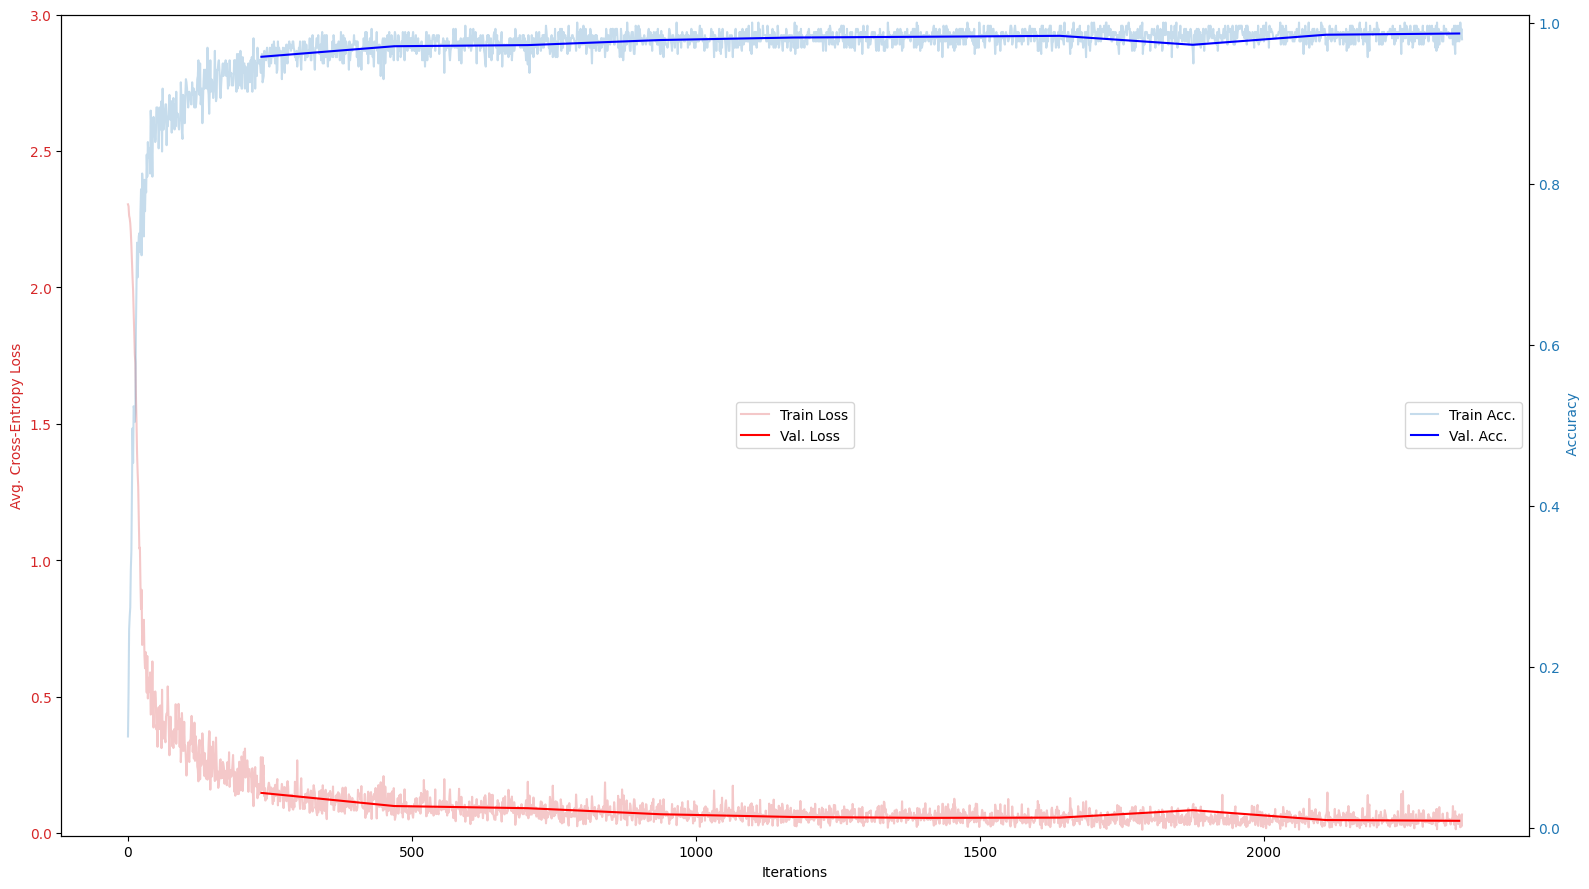

In [5]:
# Plot training and validation curves
fig, ax1 = plt.subplots(figsize=(16,9))
color = 'tab:red'
ax1.plot(range(len(loss_log)), loss_log, c=color, alpha=0.25, label="Train Loss")
ax1.plot([np.ceil((i+1)*len(train_data)/batch_size) for i in range(len(val_loss_log))], val_loss_log,c="red", label="Val. Loss")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Avg. Cross-Entropy Loss", c=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.01,3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(range(len(acc_log)), acc_log, c=color, label="Train Acc.", alpha=0.25)
ax2.plot([np.ceil((i+1)*len(train_data)/batch_size) for i in range(len(val_acc_log))], val_acc_log,c="blue", label="Val. Acc.")
ax2.set_ylabel(" Accuracy", c=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.01,1.01)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc="center")
ax2.legend(loc="center right")
plt.show()